In [81]:
## Google's Generative AI search provided the initial draft of this code. 
## I have modified it since. 
## It provided these sources: 
## https://github.com/jk96491/RL_Algorithms?tab=readme-ov-file 
## https://github.com/abyaadrafid/Deep-Reinforcement-Learning 
## I couldn't find a draft of this code in the sources, 
## so Generative AI search may have generated the code. 

import random 
import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.optim as optim 

torch.autograd.set_detect_anomaly(True) ## DEBUGGING 

class Object(object):
    pass

class ReplayBuffer(): 
    def __init__(self, capacity=10000): 
        self.n = 0 
        self.capacity = capacity 
        self.state_list = [] 
        self.action_list = [] 
        self.reward_list = [] 
        self.next_state_list = [] 
        self.done_list = [] 
        pass 
    def __len__(self):
         return self.n 
    def add(self, state, action, reward, next_state, done): 
        if self.n >= self.capacity: 
            ## discard earliest observation 
            self.state_list = self.state_list[1:] 
            self.action_list = self.action_list[1:] 
            self.reward_list = self.reward_list[1:] 
            self.next_state_list = self.next_state_list[1:] 
            self.done_list = self.done_list[1:] 
            self.n -= 1 
        pass 
        ## cast to torch  
        state = torch.tensor(state) 
        action = torch.tensor(action) 
        reward = torch.tensor(reward) 
        next_state = torch.tensor(next_state) 
        done = torch.tensor(done) 
        ## append to buffer 
        self.state_list.append(state) 
        self.action_list.append(action) 
        self.reward_list.append(reward) 
        self.next_state_list.append(next_state) 
        self.done_list.append(done) 
        self.n += 1 
        pass 
    def sample(self, batch_size=32): 
        ## sample lists 
        out = Object() ## transitions 
        out.state = [] 
        out.action = [] 
        out.reward = [] 
        out.next_state = [] 
        out.done = [] 
        for _ in range(batch_size): 
            idx = random.randint(0, self.n-1) 
            out.state.append(self.state_list[idx]) 
            out.action.append(self.action_list[idx]) 
            out.reward.append(self.reward_list[idx]) 
            out.next_state.append(self.next_state_list[idx]) 
            out.done.append(self.done_list[idx]) 
            pass 
        ## stack  
        out.state = torch.stack(out.state) 
        out.action = torch.stack(out.action) 
        out.reward = torch.stack(out.reward) 
        out.next_state = torch.stack(out.next_state) 
        out.done = torch.stack(out.done) 
        return out 
    pass 

# Define the actor and critic networks
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x))

        return action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)

        return value

# Create the actor and critic networks
actor = Actor(state_dim=4, action_dim=1)
critic = Critic(state_dim=4, action_dim=1)

# Define the optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-5)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

# Create the replay buffer
replay_buffer = ReplayBuffer(capacity=100000) 

# Define the environment
env = gym.make('CartPole-v1')

reward_list = [] 
p_list = [] # DEBUG 

# Train the agent
for episode in range(1000):
    state = env.reset()

    for t in range(1000):
        action = actor(torch.tensor(state)) 
        
        action_p = action.item() * .5 + .5 
        action_int = np.random.binomial(1, action_p) ## must be 0 or 1 
        #action_int = round(action_p)
        next_state, reward, done, _ = env.step(action_int) 

        replay_buffer.add(state, action, reward, next_state, done)

        if len(replay_buffer) > 1000:
            # Sample a batch of transitions from the replay buffer
            transitions = replay_buffer.sample(batch_size=128)

            # Calculate the target Q-values
            target_Q = critic(transitions.next_state, actor(transitions.next_state))
            target_Q = target_Q.clone().detach() * .99 + transitions.reward 

            # Calculate the current Q-values
            current_Q = critic(transitions.state, transitions.action)

            # Calculate the critic loss
            #critic_loss = torch.mean((target_Q - current_Q).pow(2)) 
            critic_loss = nn.functional.smooth_l1_loss(target_Q, current_Q)

            # Update the critic network
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            
            if len(replay_buffer) > 1000:
                # Calculate the actor loss
                actor_loss = -torch.mean(critic(transitions.state, actor(transitions.state)))

                # Update the actor network
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

        state = next_state

        if done:
            break

    # Evaluate the agent
    episode_reward = 0 
    state = env.reset() 

    for t in range(1000): 
        action = actor(torch.tensor(state))

        action_p = action.item() * .5 + .5 
        action_int = np.random.binomial(1, action_p) ## must be 0 or 1
        #action_int = round(action_p) 
        next_state, reward, done, _ = env.step(action_int) 
        p_list.append(action_p) # DEBUG 

        episode_reward += reward

        if done:
            break
    
    reward_list.append(episode_reward)
    print(f'Episode {episode}: {episode_reward}, len(replay_buffer): {len(replay_buffer)}')

/tmp/ipykernel_4225/210018763.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action)
/tmp/ipykernel_4225/210018763.py:158: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = nn.functional.smooth_l1_loss(target_Q, current_Q)


Episode 0: 14.0, len(replay_buffer): 19
Episode 1: 27.0, len(replay_buffer): 34
Episode 2: 26.0, len(replay_buffer): 48
Episode 3: 29.0, len(replay_buffer): 78
Episode 4: 14.0, len(replay_buffer): 90
Episode 5: 12.0, len(replay_buffer): 102
Episode 6: 33.0, len(replay_buffer): 119
Episode 7: 26.0, len(replay_buffer): 132
Episode 8: 15.0, len(replay_buffer): 155
Episode 9: 16.0, len(replay_buffer): 179
Episode 10: 42.0, len(replay_buffer): 201
Episode 11: 20.0, len(replay_buffer): 305
Episode 12: 38.0, len(replay_buffer): 328
Episode 13: 15.0, len(replay_buffer): 347
Episode 14: 12.0, len(replay_buffer): 371
Episode 15: 17.0, len(replay_buffer): 387
Episode 16: 16.0, len(replay_buffer): 409
Episode 17: 18.0, len(replay_buffer): 435
Episode 18: 42.0, len(replay_buffer): 448
Episode 19: 18.0, len(replay_buffer): 462
Episode 20: 28.0, len(replay_buffer): 474
Episode 21: 27.0, len(replay_buffer): 519
Episode 22: 42.0, len(replay_buffer): 529
Episode 23: 37.0, len(replay_buffer): 553
Episode

KeyboardInterrupt: 

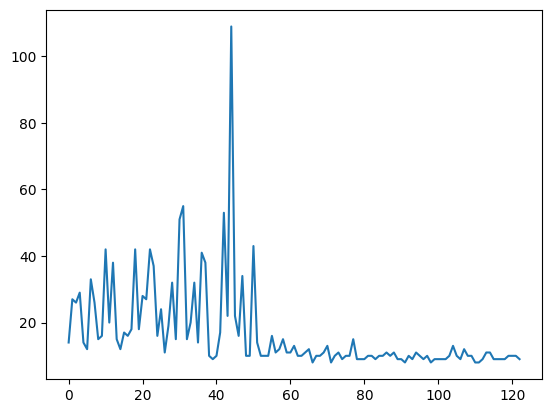

In [82]:
import matplotlib.pyplot as plt


plt.plot(reward_list)
plt.show()

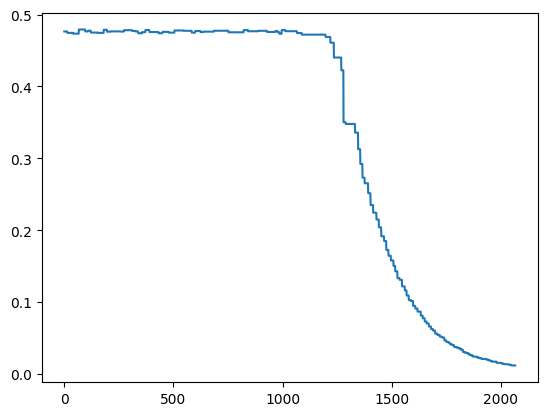

In [83]:
import matplotlib.pyplot as plt


plt.plot(p_list)
plt.show()